
Initial portfolio value = $ 1000070.06


Period 1: start date 01/02/2019, end date 02/28/2019
  Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1121179.83
  Strategy "Equally Weighted Portfolio", value begin = $ 991117.41, value end = $ 1097132.84
  Strategy "Minimum Variance Portfolio", value begin = $ 991641.10, value end = $ 1057260.84
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990014.51, value end = $ 1015464.90

Period 2: start date 03/01/2019, end date 04/30/2019
  Strategy "Buy and Hold", value begin = $ 1126131.27, value end = $ 1075001.89
  Strategy "Equally Weighted Portfolio", value begin = $ 1103357.41, value end = $ 1188840.89
  Strategy "Minimum Variance Portfolio", value begin = $ 1055088.17, value end = $ 1107270.50
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1005863.31, value end = $ 1075093.23

Period 3: start date 05/01/2019, end date 06/28/2019
  Strategy "Buy and Hold", value begin = $ 1070867.54, value end = $

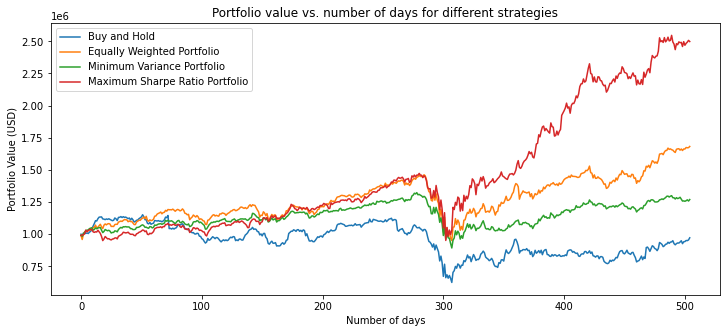

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex 
import matplotlib.pyplot as plt

# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    # Calculate current portfolio value
    cur_portf_value = np.dot(cur_prices,x_init) + cash_init
    # Calculate positions and round down to nearest integer
    x_optimal = np.floor(cur_portf_value/(20*cur_prices))
    # Calculate transaction cost
    transaction_cost = np.dot(cur_prices,np.abs(x_optimal-x_init))*0.005
    # Calculate cash remained in account
    cash_optimal = cur_portf_value - np.dot(cur_prices,x_optimal) - transaction_cost

    return x_optimal, cash_optimal



def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = 20
    c = np.zeros((n))
    lb = np.zeros((n))
    ub = np.ones((n))
    A = []
    for k in range(n):
        A.append([[0],[1]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1], senses="E")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # Get w from solver
    w_min_variance = np.array(cpx.solution.get_values())
    # Calculate current portfolio value
    cur_portf_value = np.dot(cur_prices,x_init) + cash_init
    # Calculate positions and round down to neartest integer
    x_optimal = np.floor((cur_portf_value*w_min_variance)/cur_prices)
    # Calculate transaction cost
    transaction_cost = np.dot(cur_prices,np.abs(x_optimal-x_init))*0.005
    # Calculate cash left in account
    cash_optimal = cur_portf_value - np.dot(cur_prices,x_optimal) - transaction_cost
    return x_optimal, cash_optimal


def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = 21
    c = np.zeros((n))
    lb = np.zeros((n))
    ub = [cplex.infinity]*n
    # Risk-free return is converted to daily
    coef = mu-r_rf/252
    A = []
    for k in range(n-1):
        A.append([[0,1],[coef[k],1]])
    A.append([[1],[-1]])
    # First 20 variables are y
    var_names = ["y_%s" % i for i in range(1,n)]
    # Last variable is kappa
    var_names.append('kappa')
    cpx.linear_constraints.add(rhs=[1,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    # Adjust Q so that it has shape of (21,21)
    Q=np.hstack((Q,np.zeros((20,1))))
    Q=np.vstack((Q,np.zeros((1,21))))
    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # Get optimal solution from solver
    solution = np.array(cpx.solution.get_values())
    # Get the value for y
    y = solution[:20]
    # Get the value for kappa
    kappa = solution[20]
    # Calculate w using formula: w=y/k
    w_max_sharpe = y/kappa
    # Calculate current portfolio value
    cur_portf_value = np.dot(cur_prices,x_init) + cash_init
    # Calculate positions and round down to nearest integer
    x_optimal = np.floor((cur_portf_value*w_max_sharpe)/cur_prices)
    # Calculate transaction cost
    transaction_cost = np.dot(cur_prices,np.abs(x_optimal-x_init))*0.005
    # Calculate cash left in account
    cash_optimal = cur_portf_value - np.dot(cur_prices,x_optimal) - transaction_cost
    return x_optimal, cash_optimal

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2018 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      # Logic: If the account value is not enough for portfolio adjustment and transaction cost
      #            then the unit of shares for each stock must be reduced

      # Check if cash account is negative and make adjustment
        while cash[strategy, period-1] < 0:
            # Equally distribute cash short to each stock
            cash_short = -cash[strategy, period-1]/20
            # Calculate number of units need to be reduced and round it up to nearest integer
            x_reduce = np.ceil(cash_short/cur_prices)
            # Replace with adjusted position
            x[strategy, period-1] = x[strategy, period-1] - x_reduce
            # Calculate current portfolio value
            cur_portfolio_value = np.dot(curr_positions,cur_prices) + curr_cash
            # Calculate transaction cost using adjusted position
            transaction_cost = np.dot(cur_prices,np.abs(x[strategy, period-1]-curr_positions))*0.005
            # Calculate cash remained in account after adjustment
            cash[strategy, period-1] = cur_portfolio_value - np.dot(cur_prices, x[strategy, period-1]) - transaction_cost

      # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results

plt.figure(figsize=(12,5))
for i in range(4):
    plt.plot(portf_value[i],label=strategy_names[i])
plt.legend()
plt.xlabel('Number of days')
plt.ylabel('Portfolio Value (USD)')
plt.title('Portfolio value vs. number of days for different strategies')
plt.show()


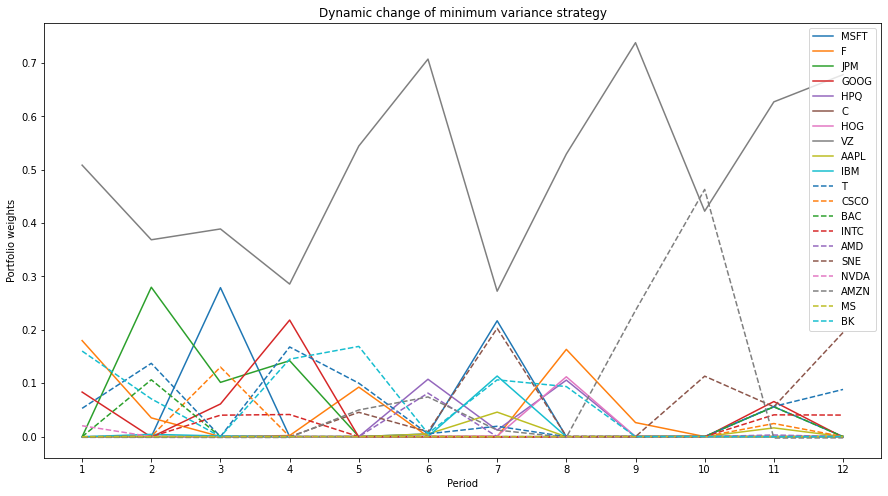

In [ ]:
# Plot dynamic change in portfolio allocation for minimum variance strategy
positions_min_val = x[2]
result_list=[]
stock_code = df.columns[1:]
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Apply formula: wi=(vi)(xi)/V
    position_ratio = positions_min_val[period-1]*cur_prices/portf_value[2][day_ind_start]
    result_list.append(position_ratio)
# Transpose the result so that rows are stocks and columns are periods
result_array=np.array(result_list).T
plt.figure(figsize=(15,8))
for j in range(20):
    if j > 9:
        plt.plot(range(1,13),result_array[j],label=stock_code[j],linestyle='dashed')
    else:
        plt.plot(range(1,13),result_array[j],label=stock_code[j])
plt.legend()
plt.xticks(range(1,13))
plt.xlabel('Period')
plt.ylabel('Portfolio weights')
plt.title('Dynamic change of minimum variance strategy')
plt.show()

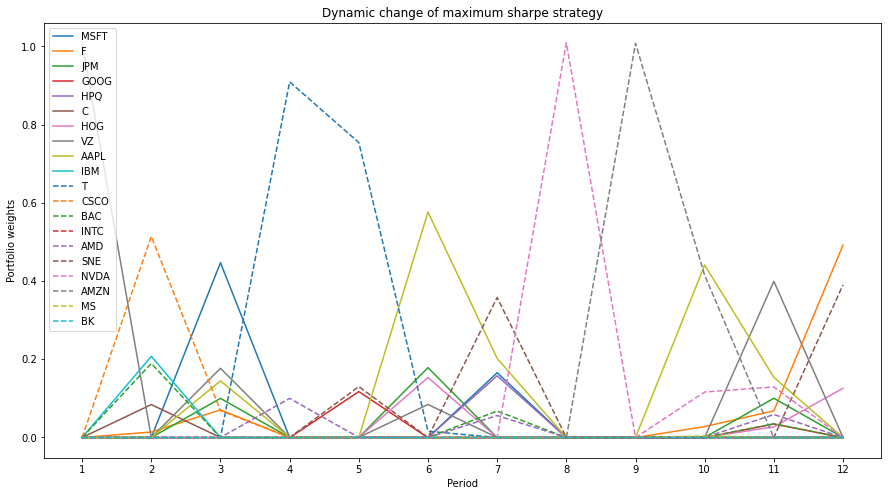

In [ ]:
# Plot dynamic change in portfolio allocation for maximum sharpe ratio strategy
positions_max_sharpe = x[3]
result_list=[]
stock_code = df.columns[1:]
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Apply formula: wi=(vi)(xi)/V
    position_ratio = positions_max_sharpe[period-1]*cur_prices/portf_value[3][day_ind_start]
    result_list.append(position_ratio)
# Transpose the result so that rows are stocks and columns are periods
result_array=np.array(result_list).T
plt.figure(figsize=(15,8))
for j in range(20):
    if j > 9:
        plt.plot(range(1,13),result_array[j],label=stock_code[j],linestyle='dashed')
    else:
        plt.plot(range(1,13),result_array[j],label=stock_code[j])
plt.legend()
plt.xticks(range(1,13))
plt.xlabel('Period')
plt.ylabel('Portfolio weights')
plt.title('Dynamic change of maximum sharpe strategy')
plt.show()

In [ ]:
# Test the program with different variations
# Idea of variation: Distribute money on each stock based on the avearge price in Nov-Dec 2018
# Mi/sum(Mi) = Vi/sum(Vi), Mi: amount of money distributed to stock i, Vi: average price of stock i
# Get the original data
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
# Extract prices in Nov-Dec 2018 and calculate mean prices
average_prices=np.mean(data_prices[day_ind_start0:day_ind_end0,:],axis=0)
# Remove data from 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]

In [ ]:
# Get the price at the beginning of period 1
cur_prices=data_prices[0,:]
# Calcualte price ratio for each stock
price_ratio = average_prices/average_prices.sum()
# Calculate money distribution to each stock
money_distribution = 1000070.06*price_ratio
# Calcualte initial position
init_positions = np.floor(money_distribution/cur_prices)
# Calculate money remained in account
cash_init = 1000070.06-np.dot(init_positions,cur_prices)


Period 1: start date 01/02/2019, end date 02/28/2019
  Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1080863.78
  Strategy "Equally Weighted Portfolio", value begin = $ 993790.79, value end = $ 1100054.13
  Strategy "Minimum Variance Portfolio", value begin = $ 992264.81, value end = $ 1043934.46
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990812.72, value end = $ 1069461.39

Period 2: start date 03/01/2019, end date 04/30/2019
  Strategy "Buy and Hold", value begin = $ 1097606.49, value end = $ 1208829.93
  Strategy "Equally Weighted Portfolio", value begin = $ 1106290.40, value end = $ 1191974.37
  Strategy "Minimum Variance Portfolio", value begin = $ 1041988.50, value end = $ 1093522.50
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1062667.05, value end = $ 1135848.69

Period 3: start date 05/01/2019, end date 06/28/2019
  Strategy "Buy and Hold", value begin = $ 1197399.50, value end = $ 1161556.36
  Strategy "Equally Weighted 

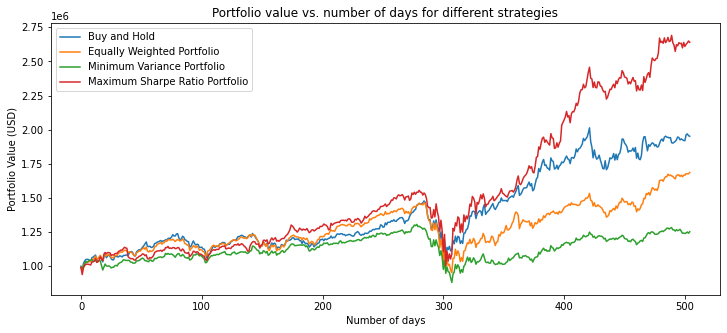

In [ ]:
# Test program
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = cash_init
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

     
      # Logic: If the account value is not enough for portfolio adjustment and transaction cost
      #            then the unit of shares for each stock must be reduced
      # Check if cash account is negative and make adjustment
        while cash[strategy, period-1] < 0:
            # Eqaully distribute cash short to each stock
            cash_short = -cash[strategy, period-1]/20
            # Calculate number of units need to be reduced and round it up to nearest integer
            x_reduce = np.ceil(cash_short/cur_prices)
            # Replace with adjusted position
            x[strategy, period-1] = x[strategy, period-1] - x_reduce
            # Calculate current portfolio value
            cur_portfolio_value = np.dot(curr_positions,cur_prices) + curr_cash
            # Calculate transaction cost using adjusted position
            transaction_cost = np.dot(cur_prices,np.abs(x[strategy, period-1]-curr_positions))*0.005
            # Calculate cash remained in account after adjustment
            cash[strategy, period-1] = cur_portfolio_value - np.dot(cur_prices, x[strategy, period-1]) - transaction_cost

      # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)
# Plot results
plt.figure(figsize=(12,5))
for i in range(4):
    plt.plot(portf_value[i],label=strategy_names[i])
plt.legend()
plt.xlabel('Number of days')
plt.ylabel('Portfolio Value (USD)')
plt.title('Portfolio value vs. number of days for different strategies')
plt.show()
